In [1]:
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
PARQUET_PATH = "../../04_merged/all_merged.parquet"

# Required fields 
TIME_KEYS   = ["donor", "year", ]
CLONE_KEYS  = ["v_gene", "j_gene", "cdr3_aa"]
NEEDED_COLS = CLONE_KEYS + TIME_KEYS + ["isotype"] +['cdr3_length'] + ['sequence','productive'] + ['replicate'] + ['v_mutation_count'] + ['v_mutation_count_aa']

# Memory filter
MEMORY_ISOTYPES = ["IgG1","IgG2","IgG3","IgG4","IgA1","IgA2",]

# Other params
CLONOTYPE_KEYS = ['v_gene', 'j_gene', 'cdr3_aa'] 

In [3]:
# Use lazy scan for scale
lf = pl.scan_parquet(PARQUET_PATH).select(NEEDED_COLS)

# filter on productive
lf = lf.filter(
    pl.col('productive')
)

# Compute Clonotypes
lf = lf.with_columns(
    (pl.col('v_gene') + pl.lit('|') + pl.col('j_gene') + pl.lit('|') + pl.col('cdr3_aa')).alias('clonotype')
)

# Group timepoints
lf = lf.with_columns(
    pl.when(pl.col('year').is_in(["2020", "2021"]))
    .then(pl.lit('Late'))
    .otherwise(pl.lit('Early'))
    .alias('timepoint')
)

# Count timepoints and donors per clonotype
lf = lf.with_columns(
    (pl.col('timepoint').n_unique().over('clonotype').alias('n_timepoints')),
    (pl.col('donor').n_unique().over('clonotype').alias('n_donors')),
)

# Add biological replicate info
bioreps = {1:1,2:2,3:3,4:4,5:5,6:6,7:1,8:2,9:3,10:4,11:5,12:6,13:1,14:2,15:3,16:4,17:5,18:6}
mini_df = pl.LazyFrame({"replicate":k,"biorep":v} for k,v in bioreps.items())
lf = lf.join(mini_df, on='replicate', how='full', )

In [4]:
# Collect data once
df = lf.collect()

In [5]:
# persistent public clonotypes
df.filter(
    (pl.col('n_timepoints') == 2)
    & (pl.col('n_donors') == 2)
).select('clonotype').n_unique()

19270

In [6]:
_pub_pers = Counter(df.filter(
    (pl.col('n_donors')>1)
    & (pl.col('n_timepoints')>1)
).select('cdr3_length')['cdr3_length'])

In [7]:
_npub_npers = Counter(df.filter(
    (pl.col('n_donors')==1)
    & (pl.col('n_timepoints')==1)
).select('cdr3_length')['cdr3_length'])

In [8]:
_pub_npers = Counter(df.filter(
    (pl.col('n_donors')>1)
    & (pl.col('n_timepoints')==1)
).select('cdr3_length')['cdr3_length'])

In [9]:
_npub_pers = Counter(df.filter(
    (pl.col('n_donors')==1)
    & (pl.col('n_timepoints')>1)
).select('cdr3_length')['cdr3_length'])

In [10]:
len_data={'pub. pers.': _pub_pers, 
          'non-pub. non-pers.': _npub_npers,
          'pub. non-pers.': _pub_npers,
          'non-pub. pers.': _npub_pers
         }
len_data2 = {'public\npersistent': _pub_pers, 
          'private\nnon-persistent': _npub_npers,
          # 'pub. non-pers.': _pub_npers,
          # 'non-pub. pers.': _npub_pers
         }

In [11]:
len_df=pd.DataFrame(len_data).fillna(0)
len_df=len_df/len_df.sum()

In [12]:
len_df2=pd.DataFrame(len_data2).fillna(0)
len_df2=len_df2/len_df2.sum()

In [13]:
len_df.sort_index(inplace=True)

In [14]:
len_df2.sort_index(inplace=True)

In [15]:
def step(x, ys, colors=None, labels=None, figfile=None, figsize=(8, 3), color=[0.3] * 3,
                ylim=None, xlim=None, xtick_interval=1, linewidth=1.25, xlabel=None, show_legend=False):
    
    sns.set_style('white')

    # set some reasonable defaults (if not provided)
    if xlim is None:
        xlim = (-0.5, len(xs))
    if ylim is None:
        ylim = (0, 1.1 * max([max(y) for y in ys]))
    if colors is None:
        colors = sns.color_palette('muted', len(ys))
    if labels is None:
        labels = [None] * len(ys)

    # plot the data
    plt.figure(figsize=figsize)
    for y, color, label in zip(ys, colors, labels):
        plot = plt.step(x, y, where='mid', color=color, linewidth=linewidth, label=label)
        plt.fill_between(x, y, step='mid', color=color, alpha=0.1)

    # axis labels and ticks
    ax = plt.gca()
    ax.set_ylabel('Frequency', size=14, labelpad=8)
    if xlabel is not None:
        ax.set_xlabel(xlabel, size=14, labelpad=8)
    plt.xticks(x[::xtick_interval], x[::xtick_interval], size='medium')
    ax.tick_params(axis='x', which='major', labelsize=12)
    ax.tick_params(axis='y', which='major', labelsize=12, length=6, width=1.25, pad=12, right=False)
    
    # hide top, left and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # axis limits
    ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    
    # legend
    if show_legend:
        plt.legend(fontsize=11, handlelength=1, loc='upper right')
    
    # save or show
    plt.tight_layout()
    if figfile is not None:
        plt.savefig(figfile)
    else:
        plt.show()

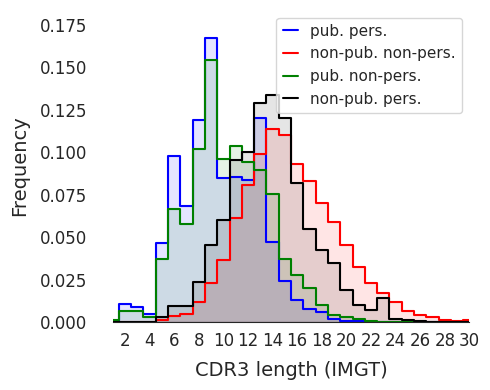

In [16]:
x = len_df.index.values
labels = len_df.columns.values
ys = [list(len_df[l]) for l in labels]
colors = ['b', 'r', 'g', 'k']

step(x, ys, colors=colors, labels=labels, xlim=[1, 30], xtick_interval=2,
     figsize=(5, 4), linewidth=1.5, xlabel='CDR3 length (IMGT)', show_legend=True,
      # figfile='./3c_public_CDR3len_step-plot.svg'
    )

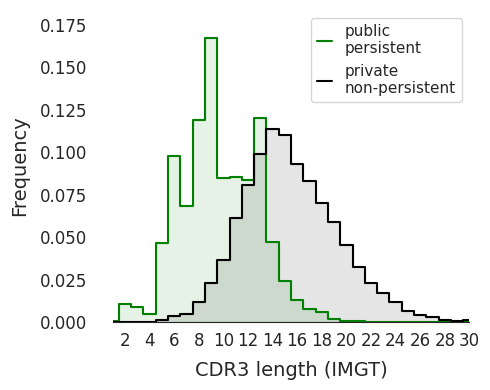

In [17]:
x = len_df2.index.values
labels = len_df2.columns.values
ys = [list(len_df2[l]) for l in labels]
colors = ['g', 'k']

step(x, ys, colors=colors, labels=labels, xlim=[1, 30], xtick_interval=2,
     figsize=(5, 4), linewidth=1.5, xlabel='CDR3 length (IMGT)', show_legend=True,
      # figfile='./3c_public_CDR3len_step-plot.svg'
    )